# Simplicity and Depression - K means 

# Objective:
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

#### Key Questions
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?


# Background:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the backoffice poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

# Data Description:
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

Data File: Credit Card Customer Data.xlsx

Steps to follow:
1. Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data. (10 marks)
2. Properly comment on the codes, provide explanations of the steps taken in the notebook and conclude your insights from the graphs. (5 marks)
3. Execute K-means clustering use elbow plot and analyse clusters using boxplot (10 marks)
4. Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot (15 marks)
5. Calculate average silhouettescore for both methods.(5marks)
6. Compare K-means clusters with Hierarchical clusters. (5 marks)
7. Analysis the clusters formed, tell us how is one cluster different from another and answer all the key questions. (10 marks)

### 1. Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data. (10 marks)
### 2. Properly comment on the codes, provide explanations of the steps taken in the notebook and conclude your insights from the graphs. (5 marks)

In [1058]:
import warnings
warnings.filterwarnings('ignore')

# Numerical libraries
import numpy as np   

# to handle data in form of rows and columns 
import pandas as pd    

#plotting missing values
import missingno as msno_plot

# importing ploting libraries
from matplotlib import pyplot as plt
%matplotlib inline

# color mapping library
import matplotlib.cm as cm

#For silhouette coefficient plotting, We will use yellowbrick library
from yellowbrick.cluster import SilhouetteVisualizer

#importing seaborn for statistical plots
import seaborn as sns

##Scale the data
from scipy.stats import zscore

#KMeans library
from sklearn.cluster import KMeans

#Silhouette samples and score library
from sklearn.metrics import silhouette_samples, silhouette_score

#Hierarchial(Agglomerative) clustering library
from sklearn.cluster import AgglomerativeClustering 

#Hierarchial clustering library
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

# distance calculation library
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

#Library for principal component analysis
from sklearn.decomposition import PCA

In [1059]:
#Reading the CSV file into pandas dataframe
ccdata = pd.read_excel("Credit Card Customer Data.xlsx")
#Raking backup of data for future use
ccdatabackup=ccdata.copy()
#Checking the shape of the data
display(ccdata.shape)
#Checking the records values
display(ccdata.head())

(660, 7)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


- 600 customer records
- 5 features for each customer record. Note: SI_NO counter not considered
- Feature scales are different. Average Credit Limit feature value is very high compared to other features. To normalize the data, we will do scaling in later steps.

In [1060]:
#Checking the data types
ccdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


- All columns are numeric and integers

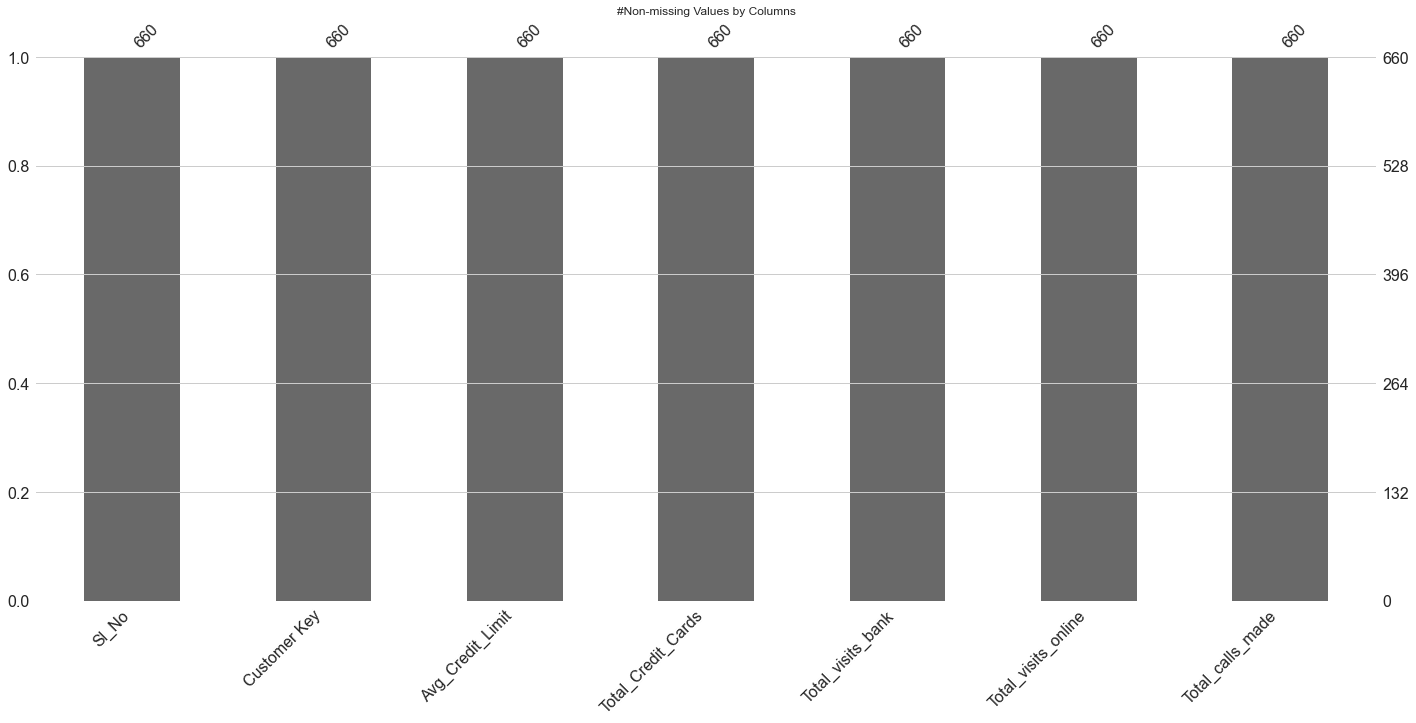

In [1061]:
#checking the missing values using Barplot
plt.title('#Non-missing Values by Columns')
msno_plot.bar(ccdata);

- No missing values

In [1062]:
#Duplicates Check
#Remove Sl_No for duplication check
ccdata.drop(columns=['Sl_No'], axis=1, inplace=True)
ccdata.duplicated().sum()

0

- No Duplicate records

In [1063]:
##Remove Sl_No and Customer Key since they are not required for now
ccdata.drop(columns=['Customer Key'], axis=1, inplace=True)
ccdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


- Customer Key column is dropped

In [1064]:
#Checking the distribution of each feature
ccdata.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.24,37625.49,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.71,2.17,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.40,1.63,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.61,2.94,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.58,2.87,0.0,1.0,3.0,5.0,10.0


- Avg_Credit_Limit and Total_visits_online may has outliers as there is lot of gap between 75% Quantile and max value. We will check outliers in later steps

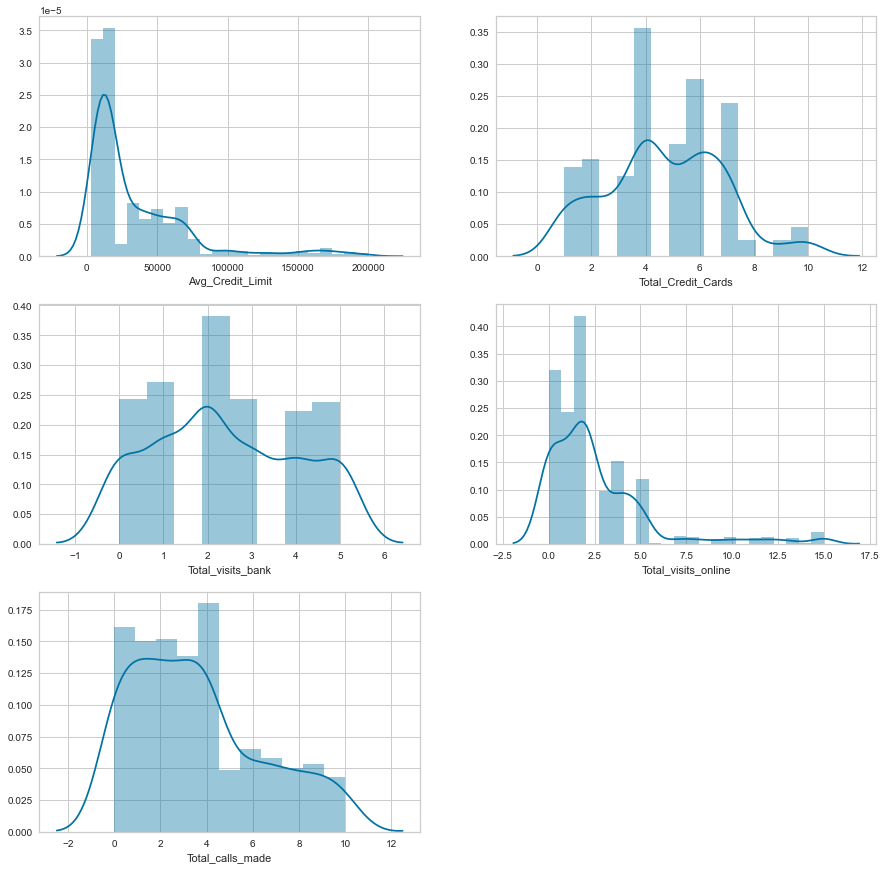

In [1065]:
#analysis of the body of distributions/tails by drawing the histogram
plt.figure(figsize=(15,15))
pos = 1
for i in ccdata.columns:
    plt.subplot(3, 2, pos)
    sns.distplot(ccdata[i])
    pos += 1 

- We can clearly see the distribution is multimodal in all features except the feature total call made
- Credit limit and online visits features are right skewed
- We can see bank visits have 3 clusters
- We can see online visits, total credits cards have 5 clusters

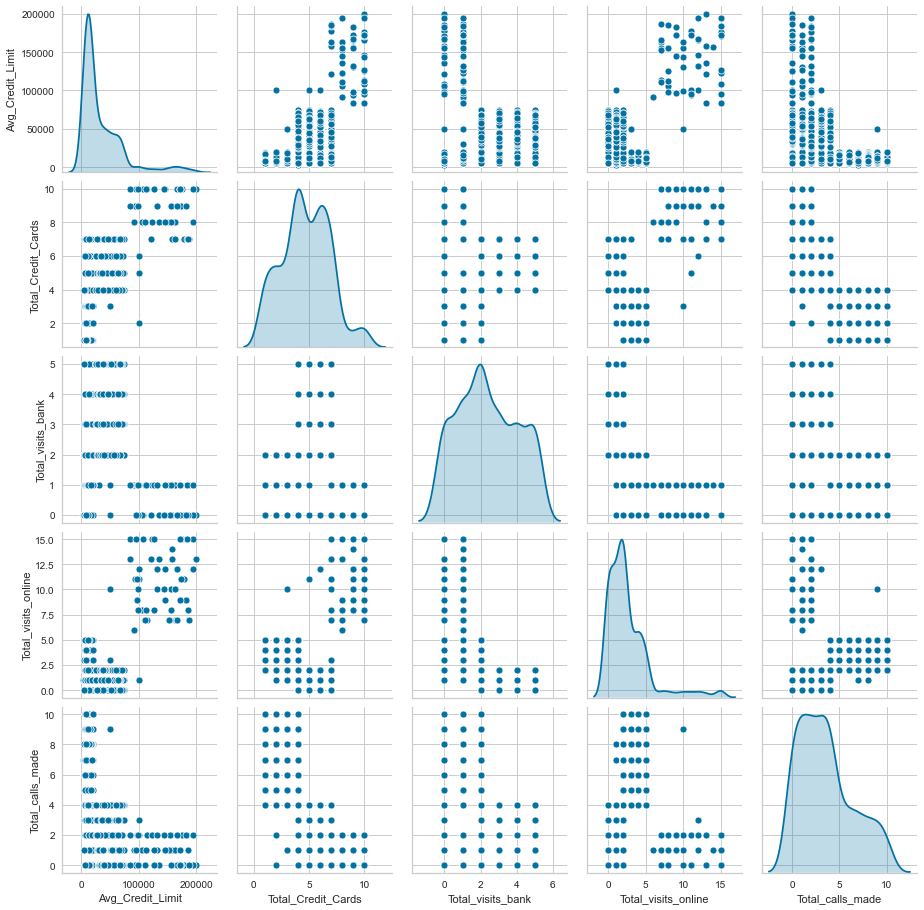

In [1066]:
#Bivariate analysis of the features
sns.pairplot(ccdata, diag_kind='kde')

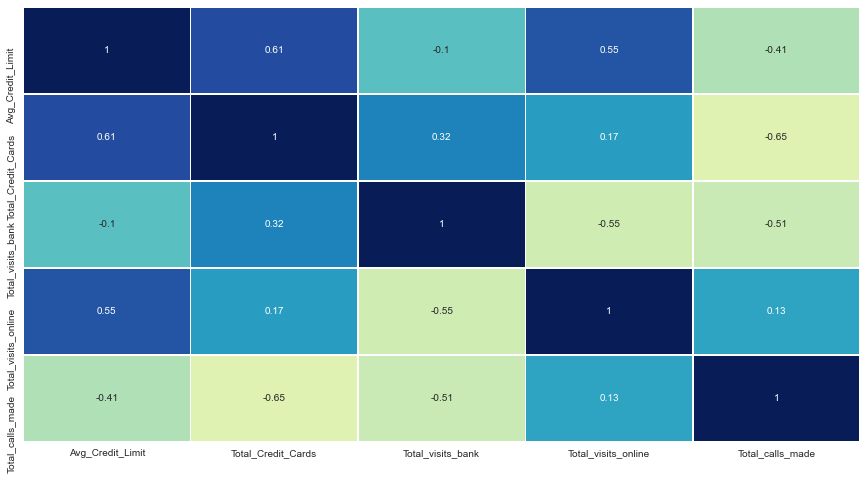

In [1067]:
#Plot Heat map to identify highly correlated variables
plt.figure(figsize=(15,8))
sns.heatmap(ccdata.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

Some correlation can be seen for following. Since the correlation is not high we will not drop the columns. 
- (Positive correlation) Total Credit Cards and Average Credit Limit
- (Positive correlation) Total Visits online and Average Credit Limit
- (Negative correlation) Total Calls made and Total Credit Cards
- (Negative correlation) Total Visits Online and Total Visits Bank
- (Negative correlation) Total Calls made and Total Visits Bank

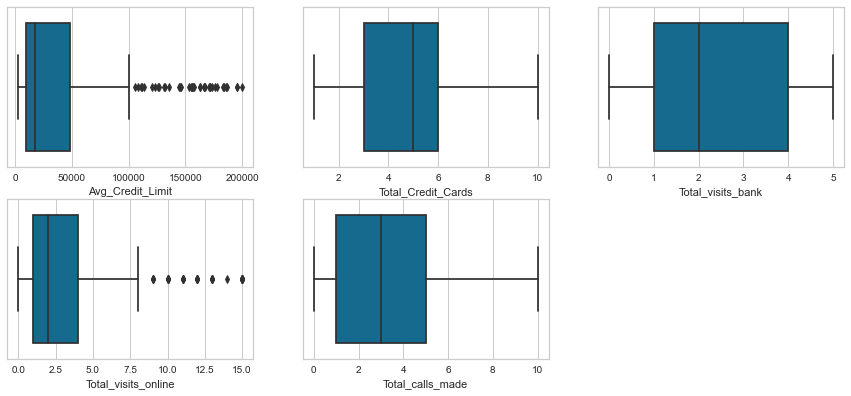

In [1068]:
#Checking Outliers
plt.figure(figsize=(15,10))
pos = 1
for i in ccdata.columns:
    plt.subplot(3, 3, pos)
    sns.boxplot(ccdata[i])
    pos += 1 

Can see outliers in following features.
- Average Credit Limit
- Total Visits Online

We will cap the outliers to corresponding 1.5 time of interquantile range on both upper and lower bounds

In [1069]:
#Capping the outliers to 1.5 time of interquantile range on both upper and lower bounds
col_names=list(ccdata.columns)
display(col_names)
ccdata_outl = ccdata.copy()
for i in col_names:
    q1, q2, q3 = ccdata_outl[i].quantile([0.25,0.5,0.75])
    IQR = q3 - q1
    lower_cap=q1-1.5*IQR
    upper_cap=q3+1.5*IQR
    ccdata_outl[i]=ccdata_outl[i].apply(lambda x: upper_cap if x>(upper_cap) else (lower_cap if x<(lower_cap) else x))

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

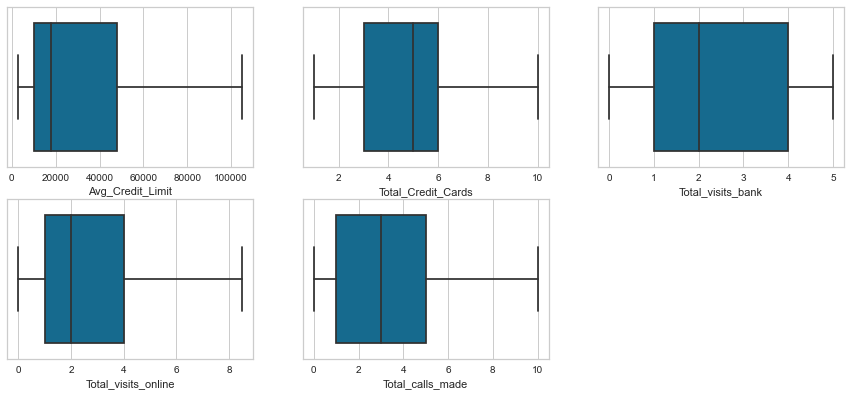

In [1070]:
#Checking Outliers after capping
plt.figure(figsize=(15,10))
pos = 1
for i in ccdata_outl.columns:
    plt.subplot(3, 3, pos)
    sns.boxplot(ccdata_outl[i])
    pos += 1 

- No more Outliers

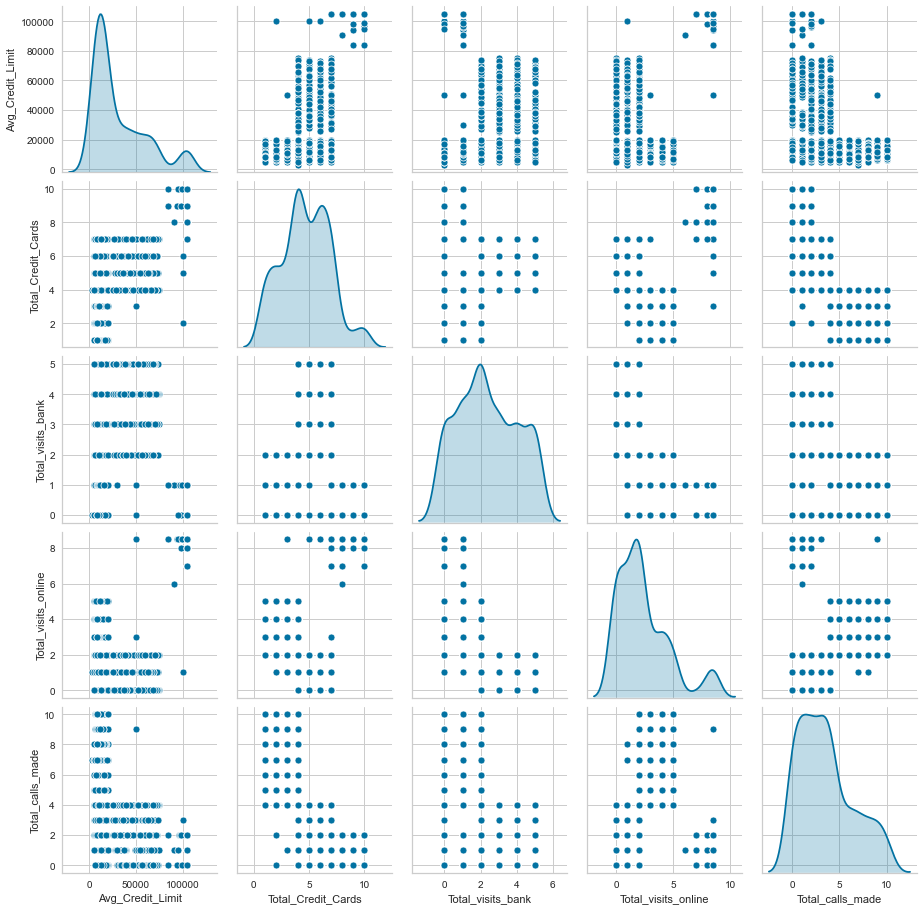

In [1071]:
#Bivariate analysis of the features after capping outliers
sns.pairplot(ccdata_outl, diag_kind='kde') 

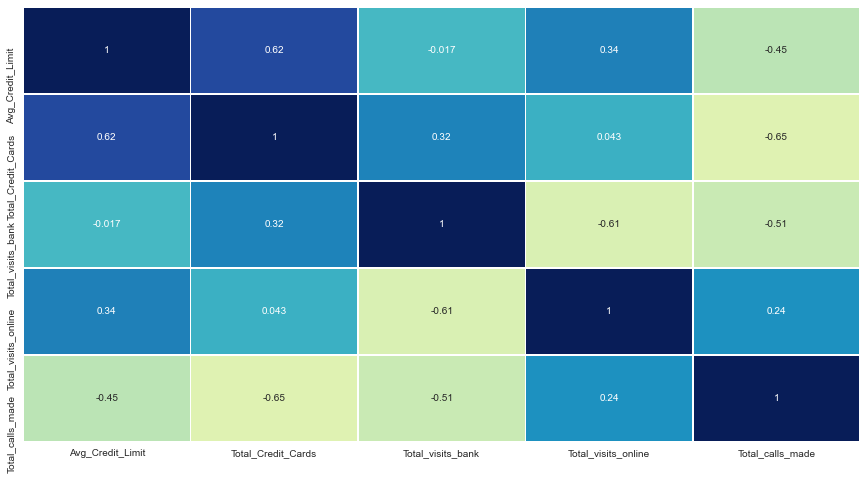

In [1072]:
#Plot Heat map after capping the outliers
plt.figure(figsize=(15,8))
sns.heatmap(ccdata_outl.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

After dropping the outliers the correlation has changed for some features. Also outliers can happen for some credit cards customers. <b> Due to this reason we will not drop the outliers</b>
- (Positive correlation) Total Credit Cards and Average Credit Limit.
- (Positive correlation) Total Visits online and Average Credit Limit. <b>We see a decrease in correlation value after capping outliers. from 0.55 to 0.34</b>
- (Negative correlation) Total Calls made and Total Credit Cards.
- (Negative correlation) Total Visits Online and Total Visits Bank. <b>We see increase in value after capping outliers. From -0.55 to -0.61</b>
- (Negative correlation) Total Calls made and Total Visits Bank.

In [1073]:
# we will normalize the data using zscore
ccdata_z = ccdata.apply(zscore)
ccdata_z.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


In [1074]:
# we will Generate descriptive statistics after normalization
ccdata_z.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,8.195465e-16,1.000758,-0.839808,-0.653623,-0.440840,0.357097,4.399975
Total_Credit_Cards,660.0,-4.006223e-15,1.000758,-1.710864,-0.787585,0.135694,0.597334,2.443892
Total_visits_bank,660.0,1.157323e-16,1.000758,-1.473731,-0.860451,-0.247170,0.979390,1.592670
Total_visits_online,660.0,1.944572e-16,1.000758,-0.888380,-0.547490,-0.206600,0.475180,4.224968
Total_calls_made,660.0,-7.112156e-16,1.000758,-1.251537,-0.902271,-0.203739,0.494794,2.241125


### 3. Execute K-means clustering use elbow plot and analyse clusters using boxplot (10 marks)

<b> Cluster Inputs </b>
1. n_clusters - int, default=8
The number of clusters to form as well as the number of centroids to generate.
2. n_init- int, default=10
Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
3. max_iter- int, default=300
Maximum number of iterations of the k-means algorithm for a single run.
4. random_state - int, RandomState instance, default=None
Determines random number generation for centroid initialization. Use an int to make the randomness deterministic. 

<b> Parameters </b>
1. cluster_centers_  - ndarray of shape (n_clusters, n_features)
Coordinates of cluster centers. If the algorithm stops before fully converging (see tol and max_iter), these will not be consistent with labels_.
2. labels_   - ndarray of shape (n_samples,)
Labels of each point
3. inertia_  - float
Sum of squared distances of samples to their closest cluster center.
4. n_iter_  - int
Number of iterations run.

In [1075]:
# We will identify the optimum K value range using elbow method 
#(Bu using multiple values of K and the elbow curve is plotted)
# Define Lists to store cluster and intra cluster distance(inertia)
clusters = []
inertia_vals = []

#Get the intra cluster distance for plotting the elbow curve
for k in range(1, 10, 1):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=42) #n_init = 15, n_jobs=10, 
    model.fit(ccdata_z)
    # append model to cluster list. Required for calculating the silhouette score
    clusters.append(model)
    # append the insertia error values
    inertia_vals.append(model.inertia_)

In [1076]:
#Calculate the silhouette score to know how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
silhouette_vals = []
for i in range(1,9,1):
    #print(clusters[i])
    silhou_score = silhouette_score(ccdata_z, clusters[i].predict(ccdata_z))
    silhouette_vals.append(silhou_score) #get average silhouette score
    print("K:",i + 1, "Clusters; Average Silhouette score:",silhou_score)

K: 2 Clusters; Average Silhouette score: 0.41842496663215445
K: 3 Clusters; Average Silhouette score: 0.5157182558881063
K: 4 Clusters; Average Silhouette score: 0.3556670619372605
K: 5 Clusters; Average Silhouette score: 0.2726898791817692
K: 6 Clusters; Average Silhouette score: 0.2555645280295032
K: 7 Clusters; Average Silhouette score: 0.24839846123470524
K: 8 Clusters; Average Silhouette score: 0.2272530484628753
K: 9 Clusters; Average Silhouette score: 0.2260668172542118


- We can see the average Silhouette score is high when K is 3 

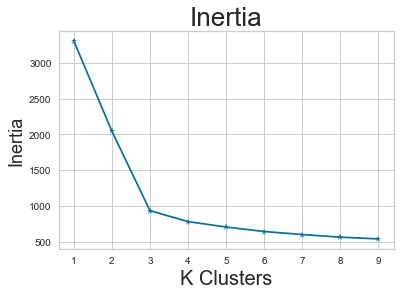

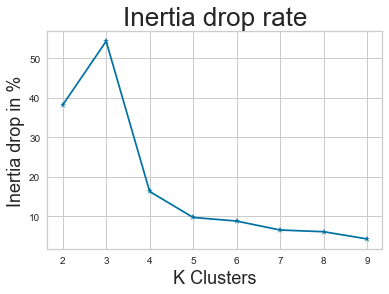

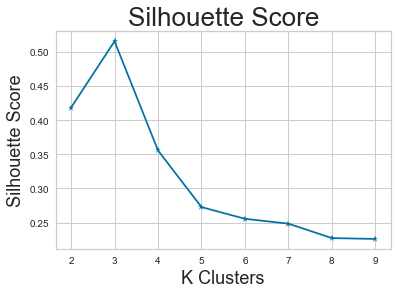

In [1077]:
# We will plot the inertia with % drop/silhouette_score vs K values
plt.title('Inertia', fontsize=26)
plt.xlabel('K Clusters', fontsize=20)
plt.ylabel('Inertia', fontsize=18)
plt.plot(range(1,10,1),inertia_vals,marker='*')
plt.show()
plt.title('Inertia drop rate', fontsize=26)
plt.xlabel('K Clusters', fontsize=18)
plt.ylabel('Inertia drop in %', fontsize=18)
plt.plot(range(2,10,1),np.diff(inertia_vals) / inertia_vals[:-1] * -100.,marker='*')
plt.show()
plt.title('Silhouette Score', fontsize=26)
plt.xlabel('K Clusters', fontsize=18)
plt.ylabel('Silhouette Score', fontsize=18)
plt.plot(range(2,10,1),silhouette_vals,marker='*')
plt.show()


- Inertia fall rate is high when K=3 clusters. The fall rate decreases from K=4 onwards. It looks like the best K value is around 3-6 clusters
- Silhoutte score is high when K=3 clusters. 

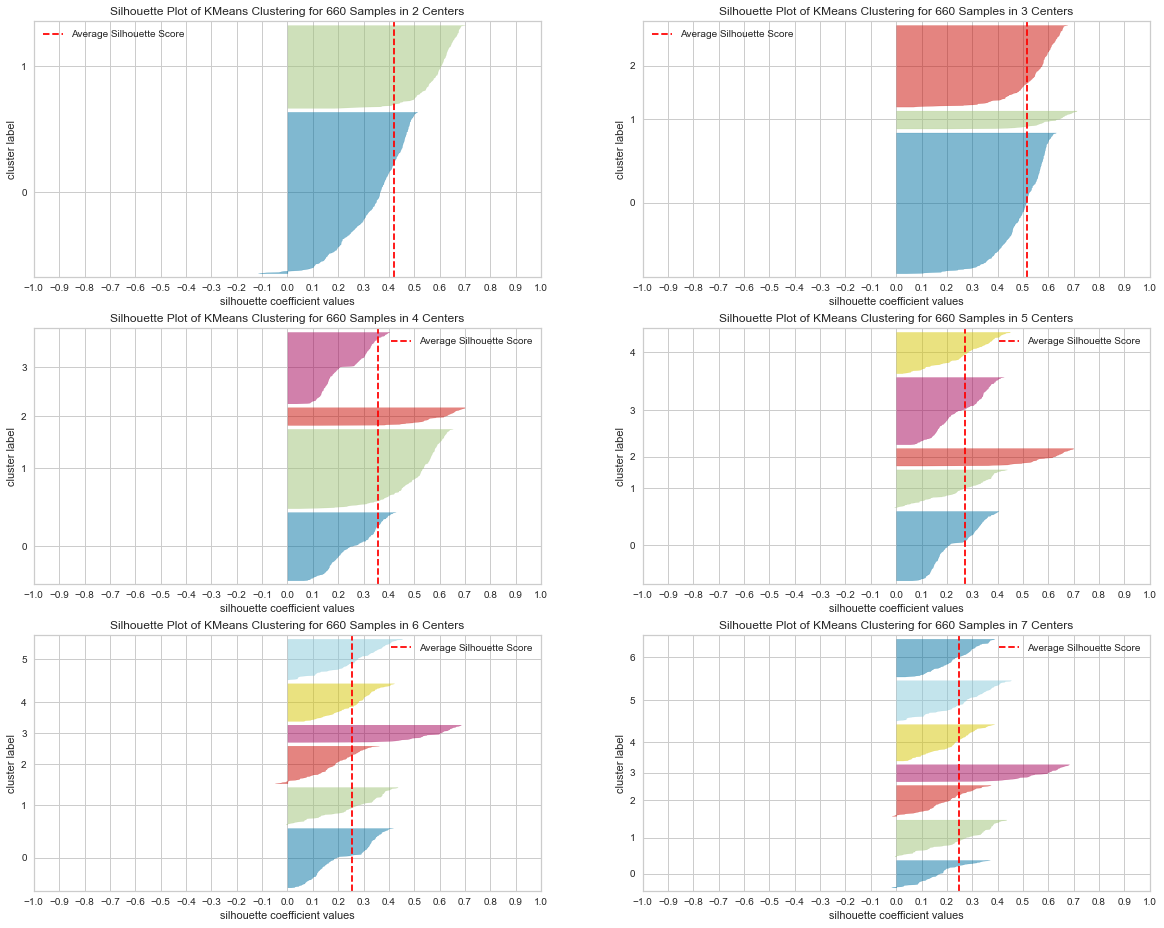

In [1078]:
#Lets plot the  silhouette coefficient for each sample on a per-cluster basis, visualizing which clusters are dense and which are not
fig, axes = plt.subplots(3,2, figsize=(20,16))
axes = axes.reshape(6)
for ax_no, k_value in enumerate(range(2,8)):
    #print("ax_no",ax_no, " k_value",k_value)
    ax = axes[ax_no]

    # Instantiate the clustering model and visualizer
    model = KMeans(n_clusters = k_value, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax)

    visualizer.fit(ccdata_z)        # Fit the data to the visualizer
    visualizer.finalize()
    ax.set_xlim(-1,1)

For n_clusters = 2,4,5,6,7 silhouette plots, we see fluctuations in silhouette score.
However for n_clusters = 3 silhouette plot, we see the silhouette score is almost same accross the clusters. One of the cluster in K=3 has less customers compared to the other 2 clusters.
<b>So we will select K=3 </b>

In [1079]:
#Set the value of k and run the KMeans with 15 different centroid seeds
kmeans1 = KMeans(n_clusters=3, n_init = 15, random_state=22)
#Fit the model with scaled data
display(kmeans1.fit(ccdata_z))
#Calculate the centroids
kmeans1_centroid_df = pd.DataFrame(kmeans1.cluster_centers_, columns = list(ccdata_z) )
display(kmeans1_centroid_df)

KMeans(n_clusters=3, n_init=15, random_state=22)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-0.595796,-1.059623,-0.901518,0.322997,1.148109
1,-0.021062,0.373690,0.666395,-0.553672,-0.553005
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


In [1080]:
## creating a new dataframe only for labels and convert it to categorical variable
kmeans1_labels = pd.DataFrame(kmeans1.labels_ , columns = list(['labels']))
kmeans1_labels['labels'] = kmeans1_labels['labels'].astype('category')
# Joining the label dataframe with the not scaled data frame.
ccdata_KM_labeled = ccdata.join(kmeans1_labels)
#Calculating the count of data points per cluster label
ccdata_KM_labeled['labels'].value_counts()

1    386
0    224
2     50
Name: labels, dtype: int64

- label 1 is biggest cluster with 386 customers
- Label 2 is smallest cluster with 50 customers

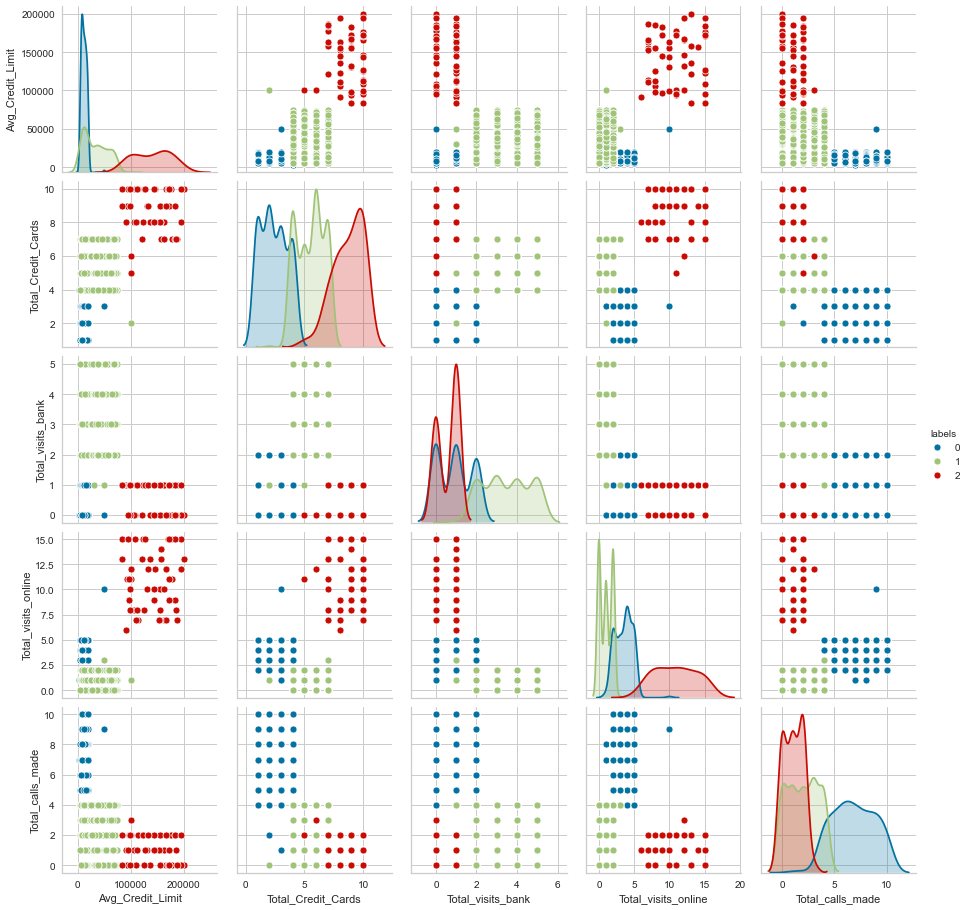

In [1081]:
# we will plot pairplot to see the the clusters
sns.pairplot(ccdata_KM_labeled,hue='labels')

We can observe the following
- label 0: We see Customers(224) with few credit cards and high customer care calls. We will name this group as <b>Low end</b> customers as their average spending limit is some what low compared to other groups.
- label 1: We see Customers(386) with average credit cards, lower credit limit and few/average calls. We will name this group as <b>Average</b> customers due to their average spending limit. 
- label 2: We see Customers(50) with more credit cards and higher credit limit. We will name this goup as <b>High End</b> Customers as they have capability to spend more due to higher credit limit

We will confirm above observations by using desriptive statistics(mean value) table below for each label group

In [1082]:
for i in [0,1,2]:
    print("Label: ", i)
    display(ccdata_KM_labeled[ccdata_KM_labeled['labels'] == i].describe().T)
    print(" ")

Label:  0


,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,224.0,12174.107143,5249.048524,3000.0,8000.0,12000.0,16000.0,50000.0
Total_Credit_Cards,224.0,2.410714,1.100783,1.0,1.0,2.0,3.0,4.0
Total_visits_bank,224.0,0.933036,0.803567,0.0,0.0,1.0,2.0,2.0
Total_visits_online,224.0,3.553571,1.218978,1.0,2.0,4.0,4.0,10.0
Total_calls_made,224.0,6.870536,1.990161,1.0,5.0,7.0,9.0,10.0


 
Label:  1


,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,386.0,33782.383420,22169.460696,5000.0,13000.0,31000.0,52000.0,100000.0
Total_Credit_Cards,386.0,5.515544,1.140069,2.0,4.0,6.0,6.0,7.0
Total_visits_bank,386.0,3.489637,1.135563,1.0,3.0,3.0,5.0,5.0
Total_visits_online,386.0,0.981865,0.857167,0.0,0.0,1.0,2.0,3.0
Total_calls_made,386.0,2.000000,1.430648,0.0,1.0,2.0,3.0,4.0


 
Label:  2


,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,50.0,141040.00,34457.877272,84000.0,108750.0,145500.0,170000.0,200000.0
Total_Credit_Cards,50.0,8.74,1.274715,5.0,8.0,9.0,10.0,10.0
Total_visits_bank,50.0,0.60,0.494872,0.0,0.0,1.0,1.0,1.0
Total_visits_online,50.0,10.90,2.880264,6.0,8.0,11.0,13.0,15.0
Total_calls_made,50.0,1.08,0.876915,0.0,0.0,1.0,2.0,3.0


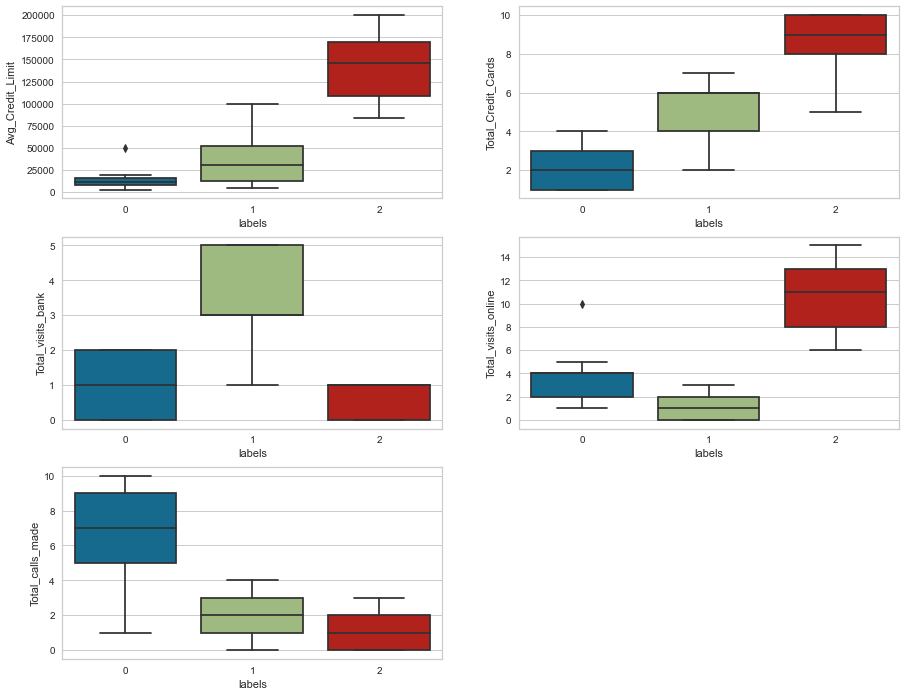

In [1083]:
# we will plot the barplot for each feature of the label
j = 1
plt.figure(figsize=(15,12))
for i in ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']:
    ax = plt.subplot(3,2,j)
    sns.boxplot(data=ccdata_KM_labeled, x="labels", y=i)    
    j = j + 1


<b>KMeans Clustering</b>

From the box plots we can observe the following

<b>Cluster Label 0 Features(Low End)</b> 224 Customers
- Average credit limit is lower side i.e. with mean of 12,174
- Total credit cards is lower side i.e. with mean of 2.4
- Bank Visits is lower for this clusteri.e. with mean of 0.9
- Online channel usage is mid level i.e. with mean of 3.5
- Calls made is very high i.e. with mean of 6.8

<b>Cluster Label 1 Features(Average)</b> 386 Customers
- Average credit limit is mid level  with a mean of 33,782
- Total credit cards is mid level i.e. with mean of 5.5
- Bank Visits is high for this cluster i.e. with mean of 3.4
- Online channel usage is low level i.e. with mean of 0.98
- Calls made is low i.e. with mean of 2

<b>Cluster Label 2 Features(High End Customers)</b> 50 Customers
- Average credit limit is very high i.e. with a mean of 141,040
- Total credit cards is higher end  i.e. with mean of 8.7
- Bank Visits is very lower for this cluster i.e. with mean of 0.6
- Online channel usage is very high i.e. with mean of 10.9
- Calls made is very low i.e. with mean of 1

### 4. Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot (15 marks)

Agglomerative Hierarchical Clustering Dendogram


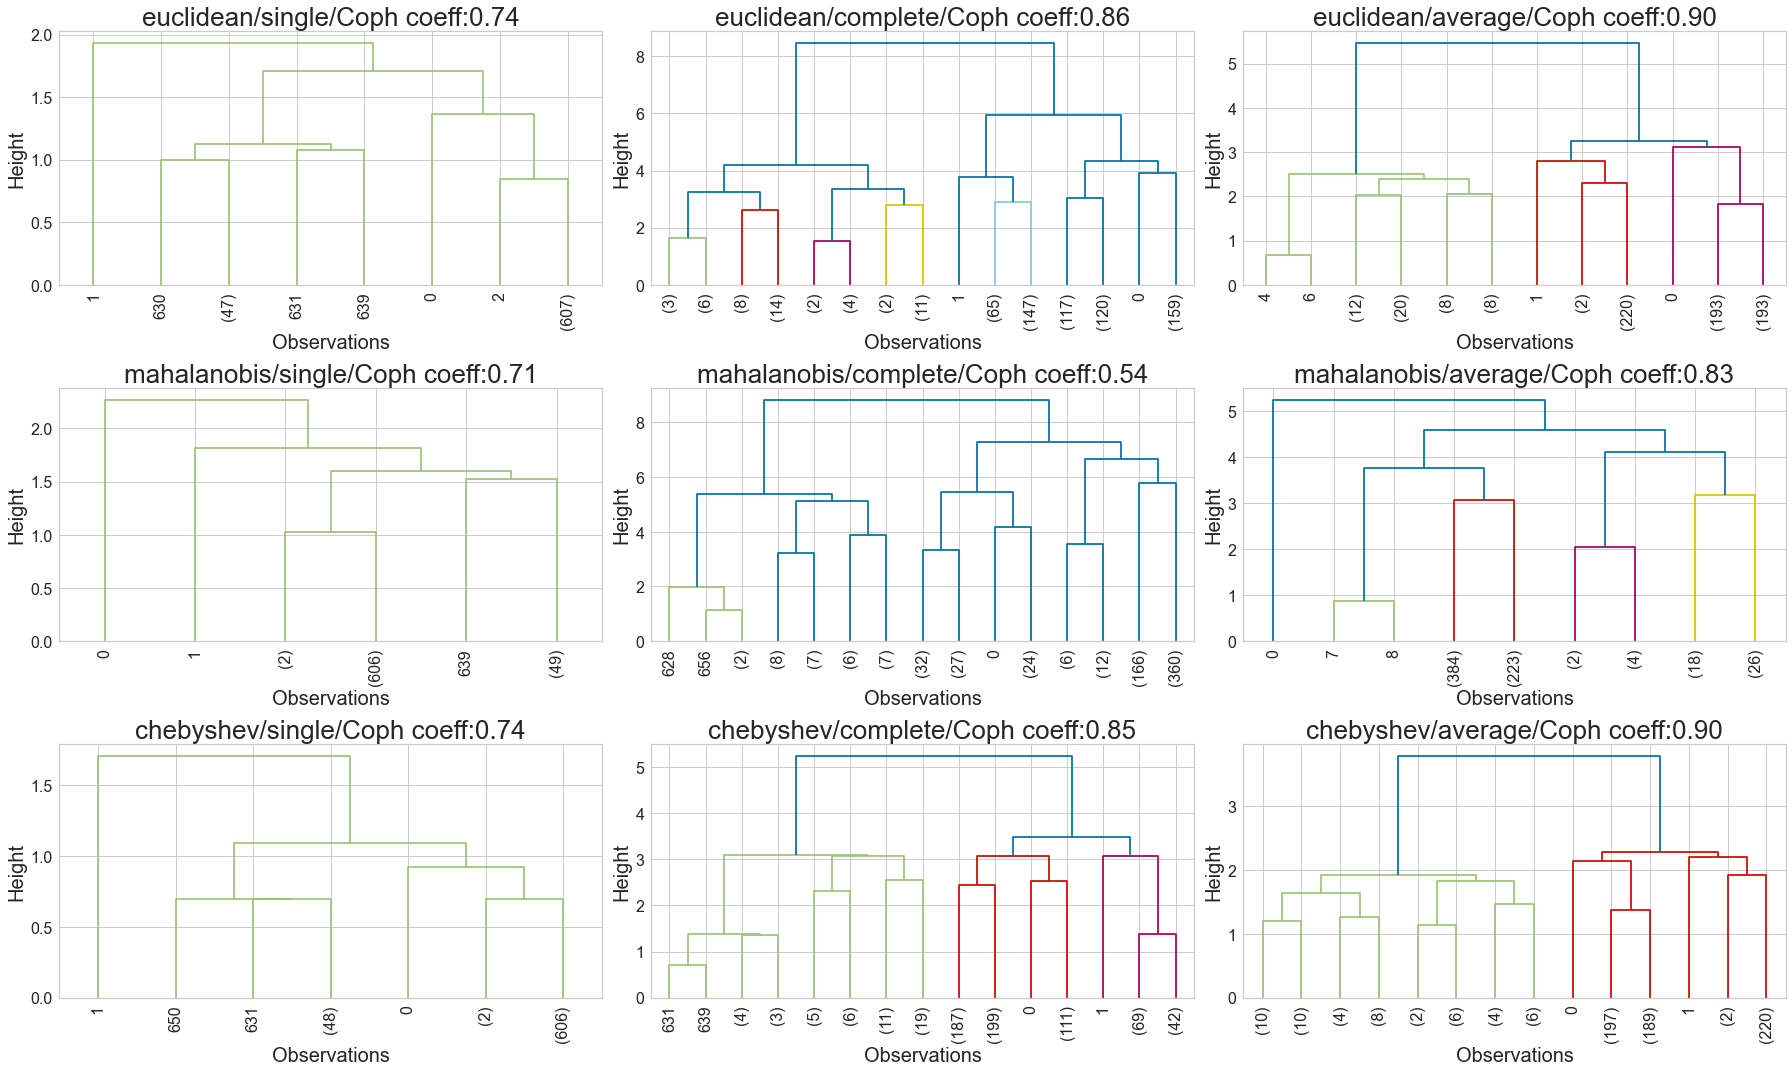

In [1084]:
#we will plot multiple dendograms with different distance metrics and linkage methods. 
#Also we will calculate the Cophenetic coeff for each dendogram
j = 1
print('Agglomerative Hierarchical Clustering Dendogram')
plt.figure(figsize=(25, 15))
# we will try 3 distance metrics 
for hie_metric in ['euclidean','mahalanobis','chebyshev']:#‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
    # we will try 3 linkage methods
    for hie_method in ['single','complete','average']:#'single','complete','average','weighted','centroid','median','ward'
        ax = plt.subplot(3,3,j)
        #Calling function to compute the distance  between two clusters.
         #We will use the standardized data to avoid bias.
        Z = linkage(ccdata_z, metric=hie_metric, method=hie_method)
        #Calling function to calculate the cophenetic distances between each observation 
         #in the hierarchical clustering defined by the above linkage Z
        #c is the the cophentic correlation distance
        #coph_dists is The cophenetic distance matrix in condensed form. 
        #The  ijth entry is the cophenetic distance between original observations i and j.
        #pdist gives the Pairwise distances between observations in n-dimensional space
        c, coph_dists = cophenet(Z , pdist(ccdata_z))
        # Drawing the Agglomerative Hierarchical Clustering Dendogram 
        str1 = '{:.2f}'.format(c)
        plt.title(hie_metric+'/'+hie_method + '/Coph coeff:' + str1 , fontsize=26)
        plt.xlabel('Observations', fontsize=20)
        plt.ylabel('Height', fontsize=20)
        # we will draw dendogram with truncation at 3 levels and coloring until 3.2 height
        dendrogram(Z, leaf_rotation=90.,color_threshold = 3.2, leaf_font_size=16. , truncate_mode= 'level', p=3, ax = ax)
        ax.tick_params(axis='y', labelsize=16)
        #        plt.show()
        plt.tight_layout()
        j = j + 1        

From the different dendograms plotted above, it looks like the below distance metric and linkage method combination have highest Cophenetic Coefficient 0.90
- Metric: euclidean; Method: average.
- Metric: chebyshev; Method: average.

We will go ahead with euclidean distance metric and average linkage method to perform clustering

In [1085]:
#creating the Agglomerative Hierarchical Clustering model
agmcmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average') #'euclidean','mahalanobis','chebyshev'
# Fitting the model
agmcmodel.fit(ccdata_z)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [1086]:
# we will create a new data frame with Zscored data and label column extracted from the Agglomerative model
ccdata_z_agmc = ccdata_z.copy()
ccdata_z_agmc['labels'] = agmcmodel.labels_
ccdata_z_agmc.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1
5,-0.387644,-0.787585,-1.473731,-0.547490,1.542593,2
6,1.740187,0.135694,-1.473731,2.861408,-0.553005,1
7,-0.520633,-0.787585,-1.473731,-0.547490,-0.902271,2
8,-0.786612,-1.249225,-1.473731,-0.206600,-0.553005,2
9,-0.839808,-0.325946,-1.473731,-0.547490,1.193326,2


In [1087]:
#Checking the number of observations in each cluster
ccdata_z_agmc['labels'].value_counts()

0    387
2    223
1     50
Name: labels, dtype: int64

In [1088]:
#Grouping by each cluster to get the centroid using mean value
ccdata_z_agmcClust = ccdata_z_agmc.groupby(['labels'])
ccdata_z_agmcClust.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,-0.022902,0.371882,0.664034,-0.552775,-0.551200
1,2.831764,1.862226,-1.105763,2.827319,-0.874330
2,-0.595179,-1.062913,-0.904453,0.325372,1.152605


In [1089]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance 
# on dendrogram. closer it is to 1, the better is the clustering
Z = linkage(ccdata_z, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(ccdata_z))
c

0.8977080867389372

- good value almost near to 1. So the feature distance and dendogram height are very correlated

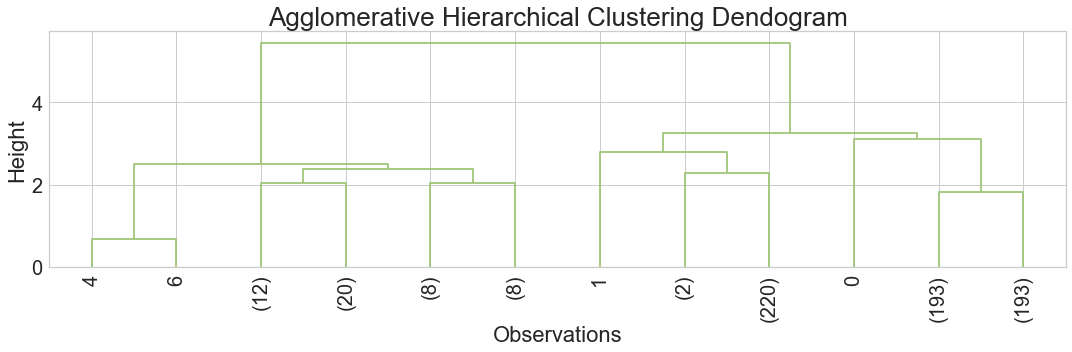

In [1090]:
# Drawing the Agglomerative Hierarchical Clustering Dendogram 
plt.figure(figsize=(15, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram', fontsize=26)
plt.xlabel('Observations', fontsize=22)
plt.ylabel('Height', fontsize=22)
plt.tick_params(axis='y', labelsize=20)
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=20. , truncate_mode= 'level', p=3)
plt.tight_layout()

In [1091]:
# we will join the labels with non standardized customer credit card data for analysis
ccdata_Agg_labeled = ccdata.join(ccdata_z_agmc['labels'])

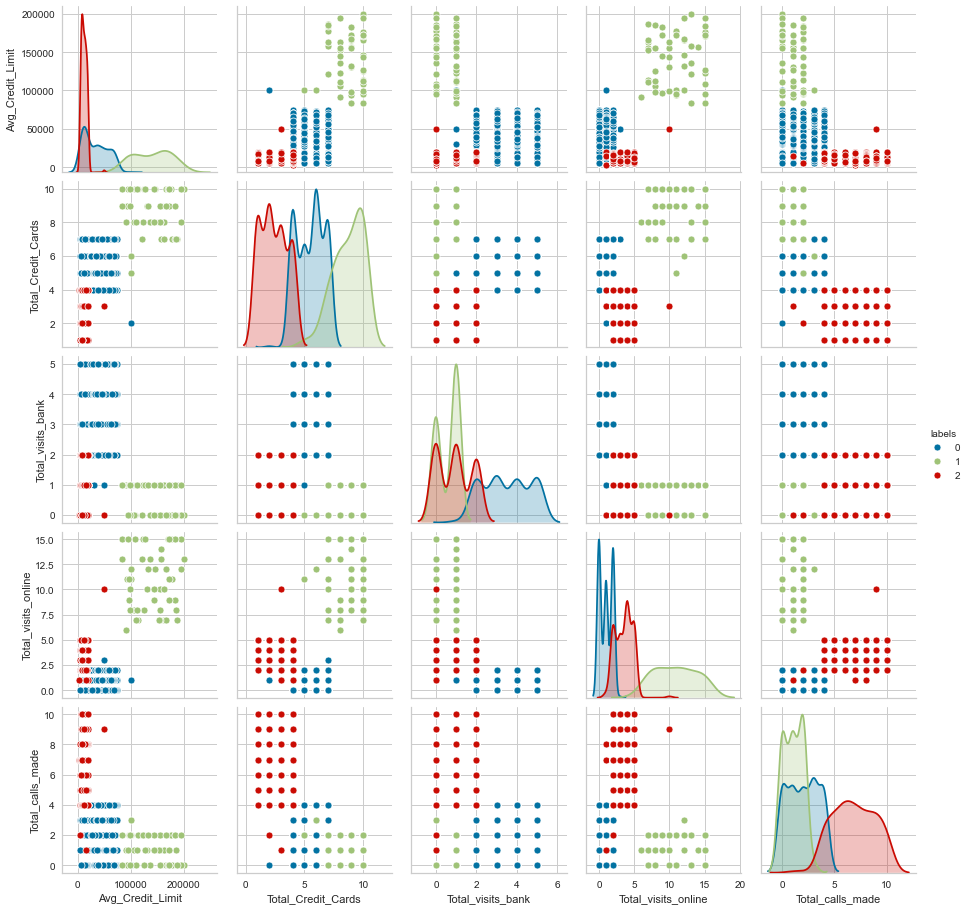

In [1092]:
# we will plot pairplot to see the the clusters
sns.pairplot(ccdata_Agg_labeled,hue='labels')

We can observe the following
- label 0: We see Customers(387) with average credit cards, lower credit limit and few/average calls. We will name this group as <b>Average</b> customers due to their average spending limit. 
- label 1: We see Customers(50) with more credit cards and higher credit limit. We will name this goup as <b>High End</b> Customers as they have capability to spend more due to higher credit limit
- label 2: We see Customers(223) with few credit cards and high customer care calls. We will name this group as <b>Low end</b> customers as their average spending limit is some what low compared to other groups.

We will confirm above observations by using desriptive statistics(mean value) table below for each label group

In [1093]:
for i in [0,1,2]:
    print("Label: ", i)
    display(ccdata_Agg_labeled[ccdata_Agg_labeled['labels'] == i].describe().T)
    print(" ")

Label:  0


,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,387.0,33713.178295,22182.542428,5000.0,13000.0,31000.0,52000.0,100000.0
Total_Credit_Cards,387.0,5.511628,1.141195,2.0,4.0,6.0,6.0,7.0
Total_visits_bank,387.0,3.485788,1.136616,1.0,2.5,3.0,5.0,5.0
Total_visits_online,387.0,0.984496,0.857619,0.0,0.0,1.0,2.0,3.0
Total_calls_made,387.0,2.005168,1.432406,0.0,1.0,2.0,3.0,4.0
labels,387.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


 
Label:  1


,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,50.0,141040.00,34457.877272,84000.0,108750.0,145500.0,170000.0,200000.0
Total_Credit_Cards,50.0,8.74,1.274715,5.0,8.0,9.0,10.0,10.0
Total_visits_bank,50.0,0.60,0.494872,0.0,0.0,1.0,1.0,1.0
Total_visits_online,50.0,10.90,2.880264,6.0,8.0,11.0,13.0,15.0
Total_calls_made,50.0,1.08,0.876915,0.0,0.0,1.0,2.0,3.0
labels,50.0,1.00,0.000000,1.0,1.0,1.0,1.0,1.0


 
Label:  2


,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,223.0,12197.309417,5249.332169,3000.0,8000.0,12000.0,16000.0,50000.0
Total_Credit_Cards,223.0,2.403587,1.098068,1.0,1.0,2.0,3.0,4.0
Total_visits_bank,223.0,0.928251,0.802171,0.0,0.0,1.0,2.0,2.0
Total_visits_online,223.0,3.560538,1.217242,1.0,2.5,4.0,4.0,10.0
Total_calls_made,223.0,6.883408,1.985271,1.0,5.0,7.0,9.0,10.0
labels,223.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0


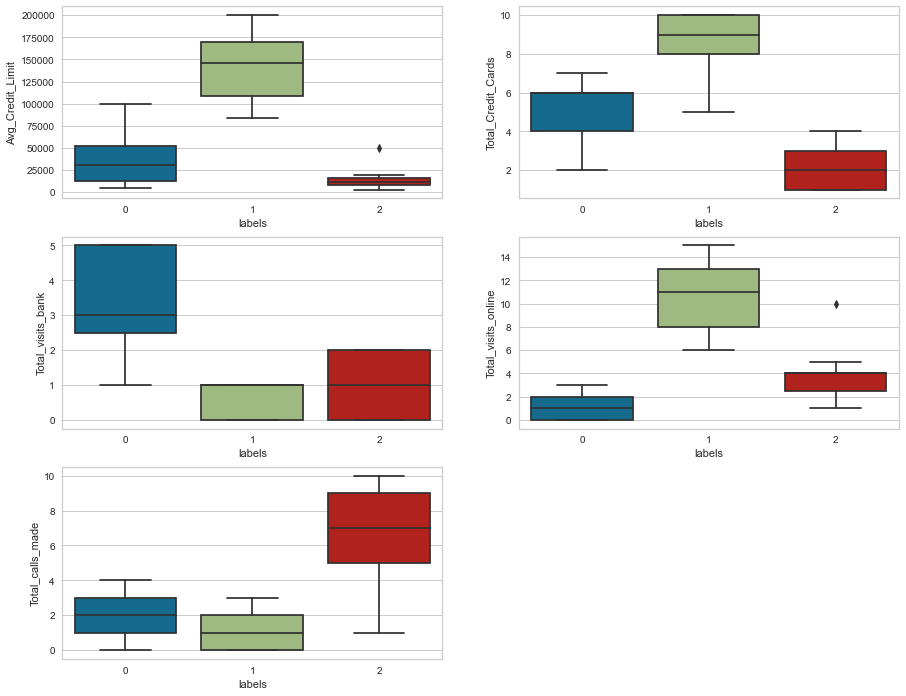

In [1094]:
j = 1
plt.figure(figsize=(15,12))
for i in ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']:
    ax = plt.subplot(3,2,j)
    sns.boxplot(data=ccdata_Agg_labeled, x="labels", y=i)    
    j = j + 1

<b>Hierarchial Agglomerative Clustering</b>

From the box plots we can observe the following

<b>Cluster Label 0 Features(Average)</b> 387 Customers
- Average credit limit is mid level  with a mean of 33713
- Total credit cards is mid level i.e. with mean of 5.5
- Bank Visits is high for this cluster i.e. with mean of 3.4
- Online channel usage is low level i.e. with mean of 0.98
- Calls made is low i.e. with mean of 2

<b>Cluster Label 1 Features(High End Customers)</b> 50 Customers
- Average credit limit is very high i.e. with a mean of 141040
- Total credit cards is higher end  i.e. with mean of 8.7
- Bank Visits is very lower for this cluster i.e. with mean of 0.6
- Online channel usage is very high i.e. with mean of 10.9
- Calls made is very low i.e. with mean of 1

<b>Cluster Label 2 Features(Low End)</b> 223 Customers
- Average credit limit is lower side i.e. with mean of 12197
- Total credit cards is lower side i.e. with mean of 2.4
- Bank Visits is lower for this cluster i.e. with mean of 0.9
- Online channel usage is mid level i.e. with mean of 3.5
- Calls made is very high i.e. with mean of 6.8

### 5. Calculate average silhouette score for both methods.(5marks)

In [1095]:
#Kmeans clustering
print('Kmeans silhouette_score', silhouette_score(ccdata_z, kmeans1_labels['labels']))
#Agglorametive clustering
print('Agglorametive silhouette_score',silhouette_score(ccdata_z, ccdata_z_agmc['labels']))

Kmeans silhouette_score 0.5157182558881063
Agglorametive silhouette_score 0.515922432650965


The silhouette_score is almost same for both methods

### 6. Compare K-means clusters with Hierarchical clusters. (5 marks)


Lets compare the clustor count for both methods 
#### KMeans Clustering
- Cluster 0 Features(Low End Customer Segment) 224 Customers
- Cluster 1 Features(Average Customer Segment) 386 Customers
- Cluster 2 Features(High End Customer Segment) 50 Customers

#### Hierachial Agglomerative Clustering
- Cluster 0 Features(Average Customer Segment) 387 Customers
- Cluster 1 Features(High End Customer Segment) 50 Customers
- Cluster 2 Features(Low End Customer Segment) 223 Customers

In [1096]:
#Lets rename the labels with the given segment names so that it is easy to compare using crosstab
kmeans1_labels_rep = kmeans1_labels.replace({'labels': {0: 'KMLowEnd', 1: 'KMAverage', 2:'KMHighEnd'}})
ccdata_z_agmc_rep = ccdata_z_agmc.replace({'labels': {0: 'HIEAverage', 1: 'HIEHighEnd', 2:'HIELowEnd'}})
kmeans1_labels_rep.rename(columns={'labels': 'KMlabels'}, inplace = True)
ccdata_z_agmc_rep.rename(columns={'labels': 'HIElabels'}, inplace = True)

In [1097]:
pd.crosstab(kmeans1_labels_rep['KMlabels'], ccdata_z_agmc_rep['HIElabels'], margins=True, margins_name="Total")

HIElabels,HIEAverage,HIEHighEnd,HIELowEnd,Total
KMlabels,,,,
KMAverage,386,0,0,386
KMHighEnd,0,50,0,50
KMLowEnd,1,0,223,224
Total,387,50,223,660


- We can see only one customer is a different cluster for Kmeans and Hierarchial clustering. Who has place either KMLowEnd or HIEAverage segments
- Overall the clusters looks similar for Kmeans and Hierarchial clustering.

## 7. Analysis the clusters formed, tell us how is one cluster different from another and answer all the key questions. (10 marks)

#### KMeans Clustering

<b>Cluster Label 0 Features(Low End)</b> 224 Customers
- Average credit limit is lower side i.e. with mean of 12,174
- Total credit cards is lower side i.e. with mean of 2.4
- Bank Visits is lower for this clusteri.e. with mean of 0.9
- Online channel usage is mid level i.e. with mean of 3.5
- Calls made is very high i.e. with mean of 6.8

<b>Cluster Label 1 Features(Average)</b> 386 Customers
- Average credit limit is mid level  with a mean of 33,782
- Total credit cards is mid level i.e. with mean of 5.5
- Bank Visits is high for this cluster i.e. with mean of 3.4
- Online channel usage is low level i.e. with mean of 0.98
- Calls made is low i.e. with mean of 2

<b>Cluster Label 2 Features(High End Customers)</b> 50 Customers
- Average credit limit is very high i.e. with a mean of 141,040
- Total credit cards is higher end  i.e. with mean of 8.7
- Bank Visits is very lower for this cluster i.e. with mean of 0.6
- Online channel usage is very high i.e. with mean of 10.9
- Calls made is very low i.e. with mean of 1

#### Hierarchial Agglomerative Clustering

<b>Cluster Label 0 Features(Average)</b> 387 Customers
- Average credit limit is mid level  with a mean of 33713
- Total credit cards is mid level i.e. with mean of 5.5
- Bank Visits is high for this cluster i.e. with mean of 3.4
- Online channel usage is low level i.e. with mean of 0.98
- Calls made is low i.e. with mean of 2

<b>Cluster Label 1 Features(High End Customers)</b> 50 Customers
- Average credit limit is very high i.e. with a mean of 141040
- Total credit cards is higher end  i.e. with mean of 8.7
- Bank Visits is very lower for this cluster i.e. with mean of 0.6
- Online channel usage is very high i.e. with mean of 10.9
- Calls made is very low i.e. with mean of 1

<b>Cluster Label 2 Features(Low End)</b> 223 Customers
- Average credit limit is lower side i.e. with mean of 12197
- Total credit cards is lower side i.e. with mean of 2.4
- Bank Visits is lower for this cluster i.e. with mean of 0.9
- Online channel usage is mid level i.e. with mean of 3.5
- Calls made is very high i.e. with mean of 6.8

### Key Questions

#### 1. How many different segments of customers are there?


3 customer segments

#### 2. How are these segments different from each other?


As explained above the customer segments can be categorized as follows
- Low End - Low credit limit and few cards. This segment calls customer care a lot compared to other segments. 
- Average - Average credit limit and average number of cards. This segment visits bank a lot compared to other segments
- High End - High credit limit and have more cards. So these customers can spend more. This segment uses online services a lot

#### 3. What are your recommendations to the bank on how to better market to and service these customers?

Best Channel for Crosssell/Upsell campaigns or Service Improvement
- High End: Online channel. Due to their high spend capability more priority should be given compared to other segments. However they are few i.e. 50
- Average: Bank channel. Large segment. Even though the credit limit is lower than the high end segment, at a segment level the total spending capability is high. 
- Low End: Customer care call center. However spend limit is low. Should be low priority.

Improve Service
- Low End: Find the reason why the low end segment calls to customer care high. Need to Customer surveys. Reducing the calls can drastically reduce the call center costs.
- Average: Find the reason why the Average segment visit bank more than other segments. Converting some of them to online service usage will drastically reduce the bank HR costs, reduce burden on Bank resources and improve service.

## PCA for Hierarchial Agglomerative and Kmeans Clustering
Using PCA we will reduce the dimensions and run the hierarchial agglomerative and Kmeans clustering to understand how clusters differ compared to non-PCA methods above

In [1098]:
#copy the normalized dataframe for pca analysis
ccdata_z_pca = ccdata_z.copy()

In [1099]:
# Create 5 components which is the max we can have as we have only 5 customer features and check the variance
pca=PCA(n_components=5, random_state = 22)
# fit the pca model and get the principal components
principalComponents = pca.fit_transform(ccdata_z_pca)
# calculate the variance of each principal component
variance=pca.explained_variance_ratio_
print("Variance explained by each component")
j=1
for i in variance:
    print("PC",j,":",(i*100))
    j+=1

Variance explained by each component
PC 1 : 45.73657823707942
PC 2 : 37.42648265143729
PC 3 : 6.401348169884019
PC 4 : 5.556880319467347
PC 5 : 4.878710622131917


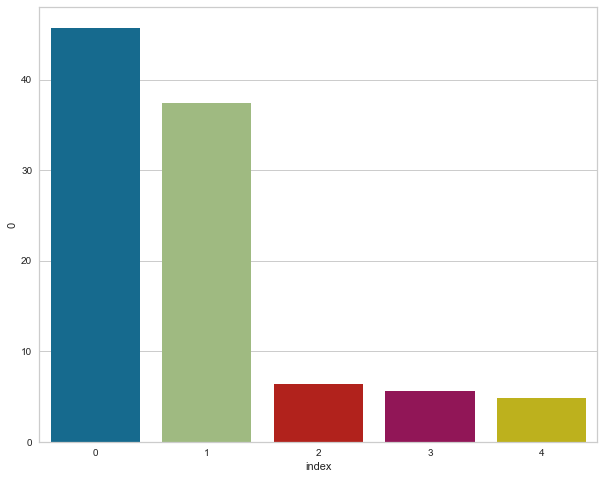

In [1100]:
#create variance dataframe
pca_data_var = pd.DataFrame(variance).reset_index()
pca_data_var[0]=round(pca_data_var[0]*100,2)
#plot the component variance
plt.figure(figsize=(10,8));
sns.barplot(x=data_var['index'],y=data_var[0]);

- we can see the principal components 0 and 1 have high variance compared to others.

In [1101]:
# we will name the principal components for heatmap analysis
pca=PCA(n_components=5, random_state = 22)
principalComponents = pca.fit_transform(ccdata_z_pca)
ccdata_z_pca = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])

In [1102]:
ccdata_z_pca.head()

,pc1,pc2,pc3,pc4,pc5
0,0.501291,0.524829,1.895862,1.200582,-1.277831
1,-1.459560,3.105588,-0.906802,0.411052,0.355547
2,0.525795,0.823979,0.089030,-1.033119,-0.196693
3,-0.362294,0.128123,0.558215,-0.729885,-0.320163
4,1.266228,3.668708,-0.099999,0.505571,0.724437


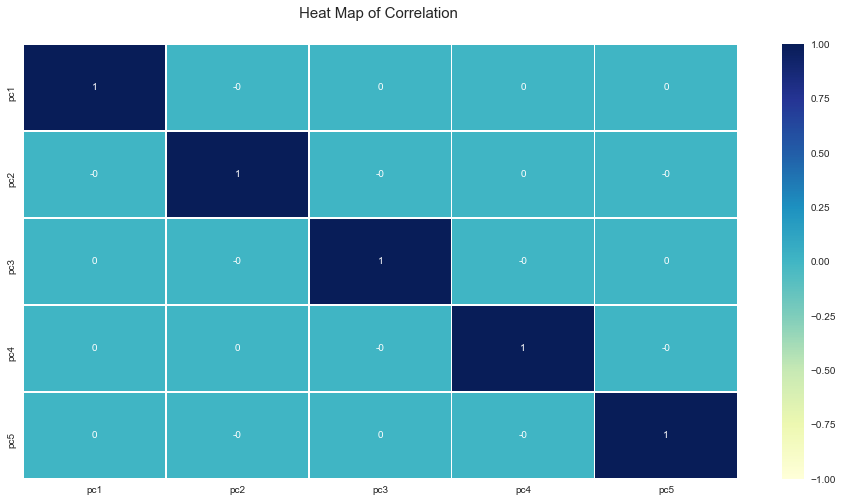

In [1103]:
#Plotting a heat map for principal components
ccdata_z_pca_corr = ccdata_z_pca.corr().round(3);
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
plt.title('Heat Map of Correlation \n',fontsize=15, pad=10)
sns.heatmap(ccdata_z_pca_corr,annot=True,cmap='YlGnBu',vmin=-1,vmax=1, linewidths=.5, center=0);

- we dont see any correlation between the principal components

In [1104]:
#plot the matrix of feature contribution to principal components
pca.components_.T

array([[ 0.48885901,  0.40323959,  0.00346147,  0.30861651, -0.70933671],
       [ 0.59767943,  0.03017103, -0.28498293, -0.74135216,  0.10512237],
       [ 0.28049227, -0.58658661, -0.6135219 ,  0.44527763,  0.05058609],
       [ 0.11178284,  0.66516108, -0.3049481 ,  0.31838769,  0.59220036],
       [-0.55912866,  0.22352726, -0.67035086, -0.23560546, -0.36404738]])

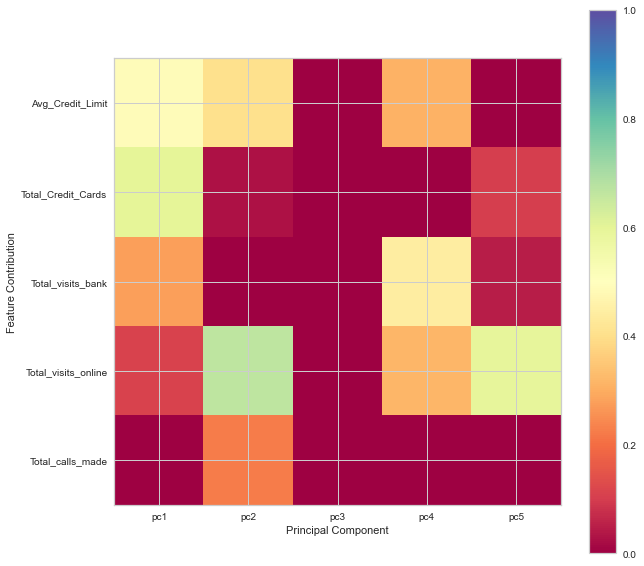

In [1105]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(pca.components_.T,  cmap= "Spectral", vmin= 0, vmax = 1)
plt.xlabel("Principal Component")
plt.ylabel("Feature Contribution")
plt.yticks(range(len(ccdata_z.columns)), ccdata_z.columns)
plt.xticks(range(len(ccdata_z_pca.columns)), ccdata_z_pca.columns)
plt.colorbar()

- For pc1, we can see the contribution by Credit cards and credit limit is high
- For pc2, we can see the contribution by online visits and credit limit is high

In [1106]:
# we will reduce dimensions by dropping low variance features pc3,pc4 and pc5
ccdata_z_pca.drop(columns = ['pc3','pc4','pc5'], inplace=True)

### Hierarchial Agglomerative clustering using principal components

In [1107]:
#creating the Agglomerative Hierarchical Clustering model
pca_agmcmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average') #'euclidean','mahalanobis','chebyshev'
# Fitting the model
pca_agmcmodel.fit(ccdata_z_pca)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [1108]:
# we will create a new data frame with Zscored PCA data and label column extracted from the Agglomerative model
ccdata_z_pca_labeled = ccdata_z_pca.copy()
ccdata_z_pca_labeled['labels'] = pca_agmcmodel.labels_
ccdata_z_pca_labeled.head(10)

,pc1,pc2,labels
0,0.501291,0.524829,2
1,-1.459560,3.105588,0
2,0.525795,0.823979,2
3,-0.362294,0.128123,0
4,1.266228,3.668708,1
5,-1.997304,0.665038,0
6,1.147495,3.349963,1
7,-0.695324,0.064917,0
8,-1.258442,0.248553,0
9,-1.747152,0.418565,0


In [1109]:
#Checking the number of observations in each cluster
ccdata_z_pca_labeled['labels'].value_counts()

2    386
0    224
1     50
Name: labels, dtype: int64

- The observations in each cluster are almost same as in "Agglomerative clustering without PCA"

In [1110]:
#Grouping by each cluster to get the centroid using mean value
ccdata_z_pca_labeledClust = ccdata_z_pca_labeled.groupby(['labels'])
ccdata_z_pca_labeledClust.mean()

,pc1,pc2
labels,,
0,-1.781650,0.729836
1,2.992098,3.531877
2,0.646334,-0.881029


In [1111]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance 
# on dendrogram. closer it is to 1, the better is the clustering
pca_Z = linkage(ccdata_z_pca, metric='euclidean', method='average')
c, coph_dists = cophenet(pca_Z , pdist(ccdata_z_pca))
c

0.9126308486377416

- good value and nearer to 1. So the PCA feature distance and dendogram height are very correlated

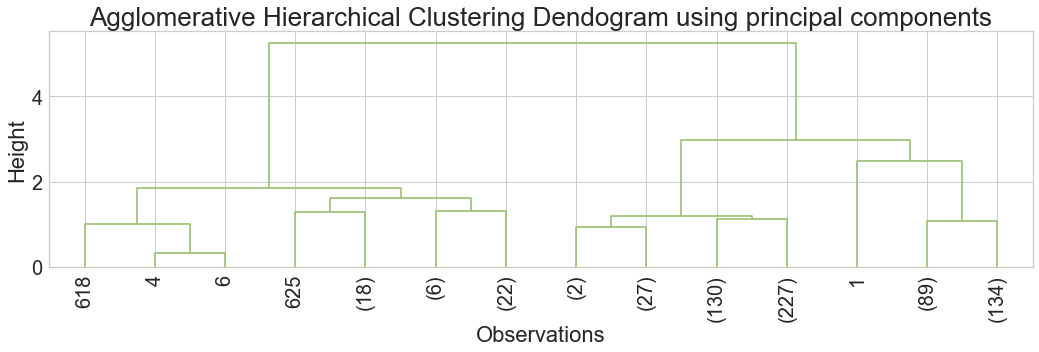

In [1112]:
# Drawing the Agglomerative Hierarchical Clustering Dendogram 
plt.figure(figsize=(15, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram using principal components', fontsize=26)
plt.xlabel('Observations', fontsize=22)
plt.ylabel('Height', fontsize=22)
plt.tick_params(axis='y', labelsize=20)
dendrogram(pca_Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=20. , truncate_mode= 'level', p=3)
plt.tight_layout()

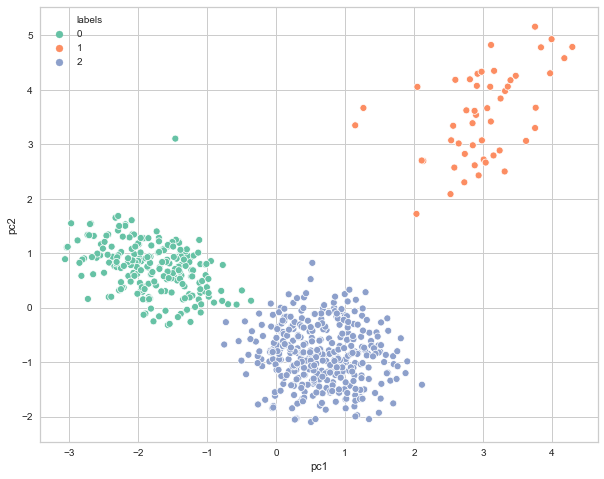

In [1113]:
# we will plot scatter plot for pc1 and pc2 components and see the inter cluster distance
plt.figure(figsize=(10,8))
sns.scatterplot(x=ccdata_z_pca_labeled.pc1, y=ccdata_z_pca_labeled.pc2, hue=ccdata_z_pca_labeled.labels, palette="Set2")

- we can see there is inter cluster distance

In [1114]:
# we will join the labels with non standardized customer credit card data for PCA analysis
ccdata_pca_Agg_labeled = ccdata.join(ccdata_z_pca_labeled['labels'])

In [1115]:
#we will calculate the silhouette_score for PCA driven Agglorametive clustering
print('Agglorametive silhouette_score',silhouette_score(ccdata_z_pca, ccdata_z_pca_labeled['labels']))

Agglorametive silhouette_score 0.6824393915408512


- we can see the silhouette_score is very good compared to "without PCA"

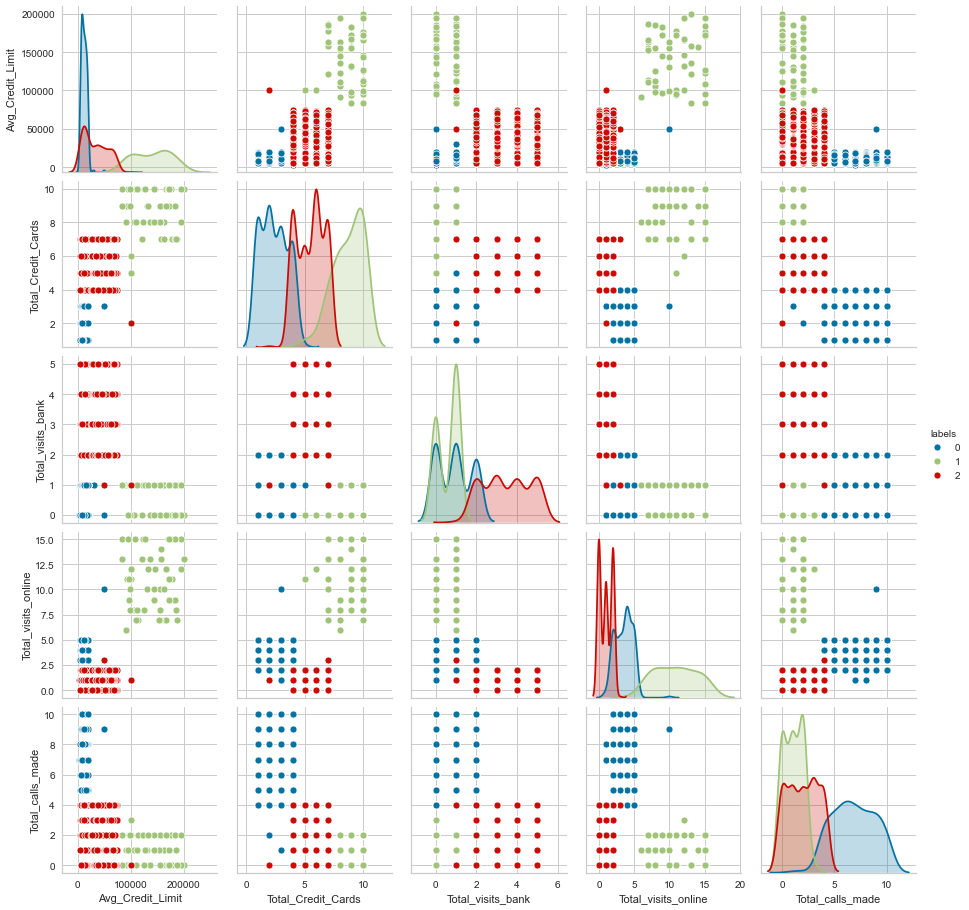

In [1116]:
# we will plot pairplot to see the PCA clusters
sns.pairplot(ccdata_pca_Agg_labeled,hue='labels')

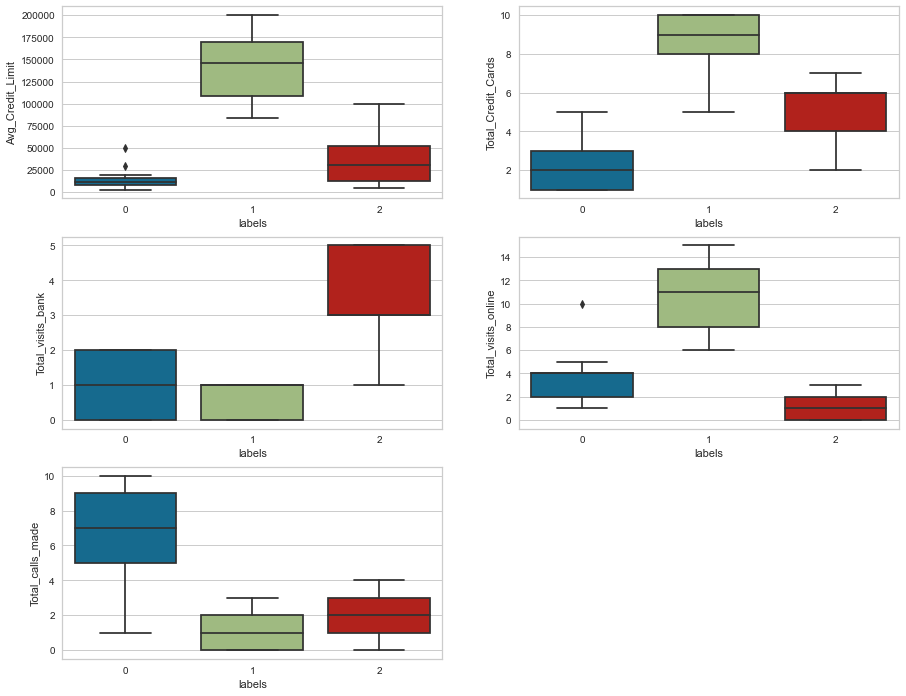

In [1117]:
j = 1
plt.figure(figsize=(15,12))
for i in ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']:
    ax = plt.subplot(3,2,j)
    sns.boxplot(data=ccdata_pca_Agg_labeled, x="labels", y=i)    
    j = j + 1

- Even though after reducing the dimensionality we can see the customer segments are same as in non PCA Hierarchail Agglomerative method. By reducing the diemensionality we can reduce the processing time

### KMeans Clustering using PCA

In [1118]:
# checking pca datframe
ccdata_z_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pc1     660 non-null    float64
 1   pc2     660 non-null    float64
dtypes: float64(2)
memory usage: 10.4 KB


In [1119]:
#Set the value of k and run the KMeans with 15 different centroid seeds
pca_kmeans1 = KMeans(n_clusters=3, n_init = 15, random_state=22)
#Fit the model with scaled data
display(pca_kmeans1.fit(ccdata_z_pca))
#Calculate the centroids
pca_kmeans1_centroid_df = pd.DataFrame(pca_kmeans1.cluster_centers_, columns = list(ccdata_z_pca) )
display(pca_kmeans1_centroid_df)

KMeans(n_clusters=3, n_init=15, random_state=22)

,pc1,pc2
0,-1.783279,0.728079
1,0.647279,-0.880009
2,2.992098,3.531877


In [1120]:
## creating a new dataframe only for labels and convert it to categorical variable
pca_kmeans1_labels = pd.DataFrame(pca_kmeans1.labels_ , columns = list(['labels']))
pca_kmeans1_labels['labels'] = pca_kmeans1_labels['labels'].astype('category')
# Joining the label dataframe with the not scaled data frame.
pca_ccdata_KM_labeled = ccdata.join(pca_kmeans1_labels)
#Calculating the count of data points per cluster label
pca_ccdata_KM_labeled['labels'].value_counts()


1    386
0    224
2     50
Name: labels, dtype: int64

- For PCA Kmeans, the count of clusters is same as non pca Kmeans method

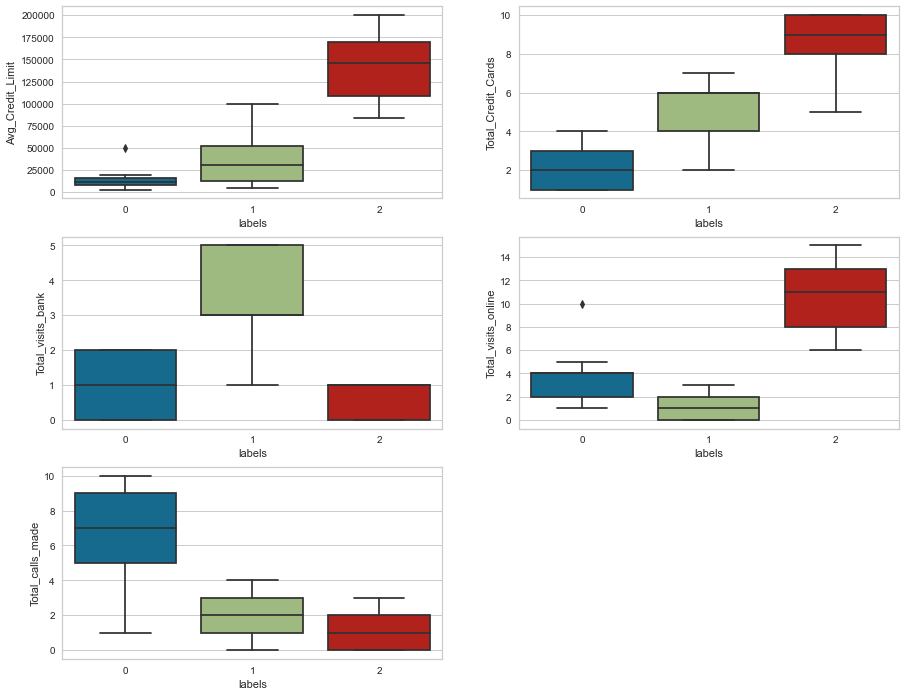

In [1121]:
# we will plot the barplot for each feature of the label
j = 1
plt.figure(figsize=(15,12))
for i in ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']:
    ax = plt.subplot(3,2,j)
    sns.boxplot(data=pca_ccdata_KM_labeled, x="labels", y=i)    
    j = j + 1

- For PCA Kmeans, Even though after reducing the dimensionality we can see the customer segments are same as in non PCA Kmeans method. By reducing the diemensionality we can reduce the processing time